##Importación de librerías necesarias

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UD3kmeans/cod.csv")

In [ ]:
df

,name,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
0,RggRt45#4697369,0,0,0.000000,0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
1,JohniceRex#9176033,0,0,0.000000,0,1,0,110,0,7,0,7.0,0,0,0,700,0.0,0,16
2,bootybootykill#1892064,0,66,1.031250,0,9,0,110,0,32,16,32.0,0,1,0,48300,0.0,0,64
3,JNaCo#5244172,3,2,0.400000,0,1,0,0,0,3,0,3.0,0,0,0,1150,0.0,0,5
4,gomezyayo_007#6596687,0,2,0.200000,0,1,0,110,0,5,1,5.0,0,0,0,1000,0.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,ImranePROPG#2085215,0,51,0.432203,0,10,0,110,0,71,11,71.0,0,0,0,49935,0.0,0,118
1554,Miguel_mor#1492856,0,0,0.000000,0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
1555,Trianthor#3462590,0,0,0.000000,0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0
1556,tinytrex594#3976133,0,0,0.000000,0,1,0,0,2,1,0,1.0,0,1,7,0,91.2,9,0


##Preprocesamiento y elección de variables relevantes para el estudio.

Filtrado de nulos

In [ ]:
df.isnull().sum()

name              0
wins              0
kills             0
kdRatio           0
killstreak        0
level             0
losses            0
prestige          0
hits              0
timePlayed        0
headshots         0
averageTime       0
gamesPlayed       0
assists           0
misses            0
xp                0
scorePerMinute    0
shots             0
deaths            0
dtype: int64

Filtrado de que por lo menos haya jugado 1

In [ ]:
df = df[df['timePlayed'] >= 1]

Conversion del dataframe to numpy array y solo nos quedamos con las columnas mas significativas

In [ ]:
df.drop(["name","level","prestige","timePlayed","averageTime",], axis = 1, inplace=True)

In [ ]:
df

,wins,kills,kdRatio,killstreak,losses,hits,headshots,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths,label
1,0,0,0.000000,0,0,0,0,0,0,0,700,0.000000,0,16,0
2,0,66,1.031250,0,0,0,16,0,1,0,48300,0.000000,0,64,0
3,3,2,0.400000,0,0,0,0,0,0,0,1150,0.000000,0,5,0
4,0,2,0.200000,0,0,0,1,0,0,0,1000,0.000000,0,10,0
5,684,27011,1.066743,18,10,98332,5113,588,6063,305319,3932335,255.672035,403651,25321,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1173,45764,1.078627,20,14,128437,7146,1232,7133,409748,8740718,214.819438,538185,42428,1
1552,0,0,0.000000,0,0,0,0,0,0,0,200,0.000000,0,2,0
1553,0,51,0.432203,0,0,0,11,0,0,0,49935,0.000000,0,118,0
1556,0,0,0.000000,0,0,2,0,0,1,7,0,91.200000,9,0,0


son los campos mas significativos a la hora de valorar un jugador

In [ ]:
df.columns

Index(['wins', 'kills', 'kdRatio', 'killstreak', 'losses', 'hits', 'headshots',
       'gamesPlayed', 'assists', 'misses', 'xp', 'scorePerMinute', 'shots',
       'deaths'],
      dtype='object')

In [ ]:
df_x = df.to_numpy()

In [ ]:
X = df_x

In [ ]:
# X

## Detección del número de clusters

Por tratarse de un caso real el número de clusters $K$ es desconocido. Vamos a aplicar  el criterio basado en el BIC para el cálculo de este hiperparámetro, para ello haremos uso de la función *BIC* (previamente empleada en el Ejemplo 6.1).  

Tras ejecutar el siguiente código podemos observar que el BIC decrece hasta $K=4$ y a partir de este, aumenta. Por lo tanto $K=4$ será el valor elegido.

In [ ]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

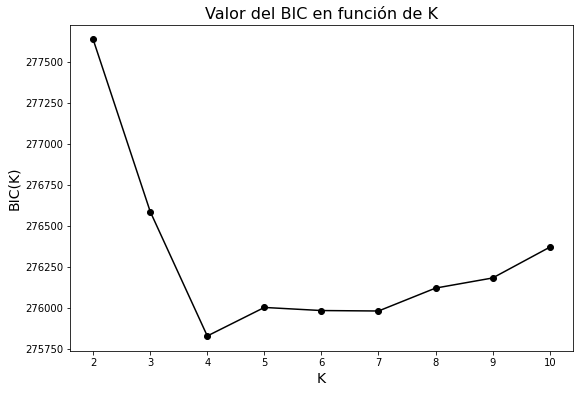

In [ ]:
## Calculo del BIC
Kmax = 10
BIC_array = []
for k in range(2, Kmax+1):
  kmeans = KMeans(n_clusters=k, n_init=15, random_state=100)
  grupos = kmeans.fit_predict(X)
  BIC_array.append(BIC(k, grupos, X))

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(9, 6))
plt.plot(np.arange(2, Kmax+1), BIC_array, "ko-")
plt.title("Valor del BIC en función de K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.show()

## Detección de outliers (anomalías)

Vamos a aplicar el método de Jackknife para detectar las observaciones influyentes.  El siguiente código detecta los outliers y los elimina del análisis y los representa visualmente. Notar que si el número de réplicas en el número de veces que se realiza el algoritmo de las k-medias es pequeño el procedimiento detecta diferentes conjunto de outliers ya que llega a diferentes soluciones. Hemos fijado este valor a $30$.

In [ ]:
## Detección de outliers
N = X.shape[0] # Número de observaciones
K = 4 # Número de clusters el que se ve en el grafico

SSE = []
for i in range(0, N):
  X_sin_i = np.delete(X, i, axis=0) # Eliminamos la observación i
  # Aplicamos K-medias a X_sin_i y obtenemos el índice SSE
  kmeans = KMeans(n_clusters=K, n_init=30, random_state=100).fit(X_sin_i)
  SSE.append(kmeans.inertia_)

In [ ]:
min(SSE)

372351393315777.4

In [ ]:
max(SSE)

422524457424516.7

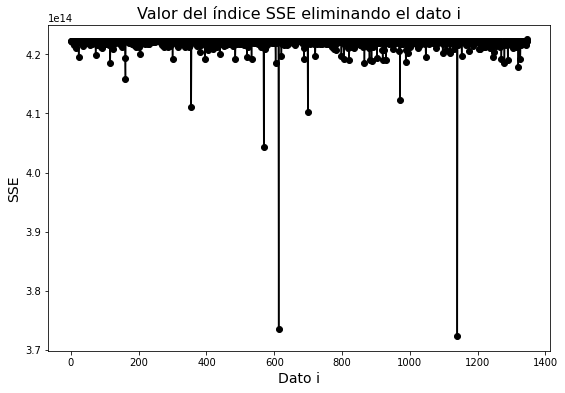

In [ ]:
## Detección visual de outliers
# Dibujamos el SSE obtenido eliminando cada observación
plt.figure(figsize=(9, 6))
plt.plot(np.arange(0, N), SSE, "ko-")
plt.title("Valor del índice SSE eliminando el dato i", fontsize=16)
plt.xlabel("Dato i", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.show()

In [ ]:
## Detección analítica de outliers
sigma = np.std(SSE) # Desviación típica de SSE
mu = np.mean(SSE) # Media
umbral = 2 # Umbral: 2 para distribuciones normales y 3 para cualquier otra distribución

outliers = []
for i in range(0, N):
  if np.abs(SSE[i]-mu) > umbral*sigma:
    outliers.append(i)
print(outliers)

[161, 355, 569, 613, 699, 971, 1140]


In [ ]:
## Eliminación de los outliers
X_new = np.delete(X, outliers, axis=0)
X_new.shape

(1341, 14)

In [ ]:
df = df.drop(outliers,axis=0)

## Determinación de patrones y estudio

Finalmente calculamos los patrones mediante el algoritmo $K-$means, los repesentamos gráficamente

In [ ]:
## Cálculo de patrones
kmeans = KMeans(n_clusters=K, n_init=30, random_state=100)
pred = kmeans.fit_predict(X_new)
centroides = kmeans.cluster_centers_

In [ ]:
centroides

In [ ]:
df["label"] = pred

In [ ]:
df.head().T

,1,2,3,4,5
wins,0.0,0.00000,3.0,0.0,6.840000e+02
kills,0.0,66.00000,2.0,2.0,2.701100e+04
kdRatio,0.0,1.03125,0.4,0.2,1.066743e+00
killstreak,0.0,0.00000,0.0,0.0,1.800000e+01
losses,0.0,0.00000,0.0,0.0,1.000000e+01
hits,0.0,0.00000,0.0,0.0,9.833200e+04
headshots,0.0,16.00000,0.0,1.0,5.113000e+03
gamesPlayed,0.0,0.00000,0.0,0.0,5.880000e+02
assists,0.0,1.00000,0.0,0.0,6.063000e+03
misses,0.0,0.00000,0.0,0.0,3.053190e+05


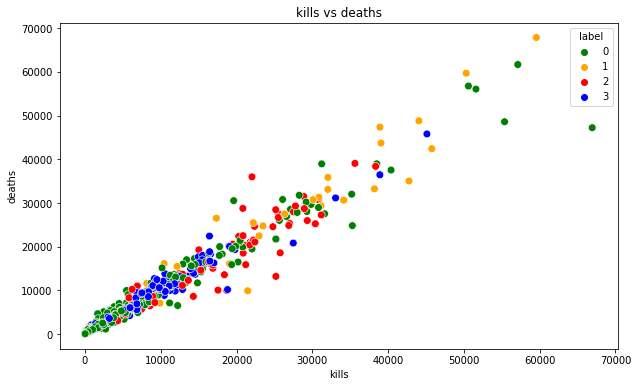

In [ ]:
#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'kills',y = 'deaths',hue="label",palette=['green','orange','red','blue'], legend='full', data = df ,s = 60 )
plt.xlabel('kills')
plt.ylabel('deaths') 
plt.title('kills vs deaths')
plt.show()

In [ ]:
N_patron = np.bincount(pred) # Contar el número veces del label que se repite 
tabla = pd.DataFrame(columns=["Número de grupo", "Número de observaciones del grupo","Centroide:característica wins",
                              "Centroide:característica kills", "Centroide:característica kdRatio","Centroide:característica killstreak",
                              "Centroide:característica losses", "Centroide:característica hits","Centroide:característica headshots",
                              "Centroide:característica gamesPlayed", "Centroide:característica assists","Centroide:característica misses",
                              "Centroide:característica xp", "Centroide:característica scorePerMinute","Centroide:característica shots",
                              "Centroide:característica deaths"  
                            ])

# Index(['wins', 'kills', 'kdRatio', 'killstreak', 'losses', 'hits', 'headshots',
#        'gamesPlayed', 'assists', 'misses', 'xp', 'scorePerMinute', 'shots',
#        'deaths'],


for k in range(K):
  tabla.loc[k, "Número de grupo"] = k
  tabla.loc[k, "Número de observaciones del grupo"] = N_patron[k]  
  tabla.loc[k, "Centroide:característica wins"] = centroides[k][0]
  tabla.loc[k, "Centroide:característica kills"] = centroides[k][1]
  tabla.loc[k, "Centroide:característica kdRatio"] = centroides[k][2]
  tabla.loc[k, "Centroide:característica killstreak"] = centroides[k][3]
  tabla.loc[k, "Centroide:característica losses"] = centroides[k][4]
  tabla.loc[k, "Centroide:característica hits"] = centroides[k][5]
  tabla.loc[k, "Centroide:característica headshots"] = centroides[k][6]
  tabla.loc[k, "Centroide:característica gamesPlayed"] = centroides[k][7]
  tabla.loc[k, "Centroide:característica assists"] = centroides[k][8]
  tabla.loc[k, "Centroide:característica misses"] = centroides[k][9]
  tabla.loc[k, "Centroide:característica xp"] = centroides[k][10]
  tabla.loc[k, "Centroide:característica scorePerMinute"] = centroides[k][11]
  tabla.loc[k, "Centroide:característica shots"] = centroides[k][12]
  tabla.loc[k, "Centroide:característica deaths"] = centroides[k][13]
    

# Mostrar la tabla
display(tabla)

,Número de grupo,Número de observaciones del grupo,Centroide:característica wins,Centroide:característica kills,Centroide:característica kdRatio,Centroide:característica killstreak,Centroide:característica losses,Centroide:característica hits,Centroide:característica headshots,Centroide:característica gamesPlayed,Centroide:característica assists,Centroide:característica misses,Centroide:característica xp,Centroide:característica scorePerMinute,Centroide:característica shots,Centroide:característica deaths
0,0,967,37.402275,666.274043,0.637884,4.741468,3.031024,2070.377456,115.1303,25.129266,134.024819,9521.467425,145617.653568,109.332949,11591.844881,775.555326
1,1,52,975.961538,28564.519231,1.039569,17.346154,17.153846,76841.519231,4663.076923,776.980769,5184.615385,321762.423077,7215001.903846,148.210727,398603.942308,28548.923077
2,2,102,656.088235,17185.147059,1.001854,18.77451,13.313725,45877.333333,2793.921569,514.794118,3150.098039,200030.088235,3955880.068627,158.13221,245906.009804,17532.666667
3,3,220,342.481818,7818.954545,0.954394,14.609091,11.340909,22283.55,1366.990909,264.836364,1405.318182,100085.504545,1607777.322727,171.46155,122369.054545,8239.863636


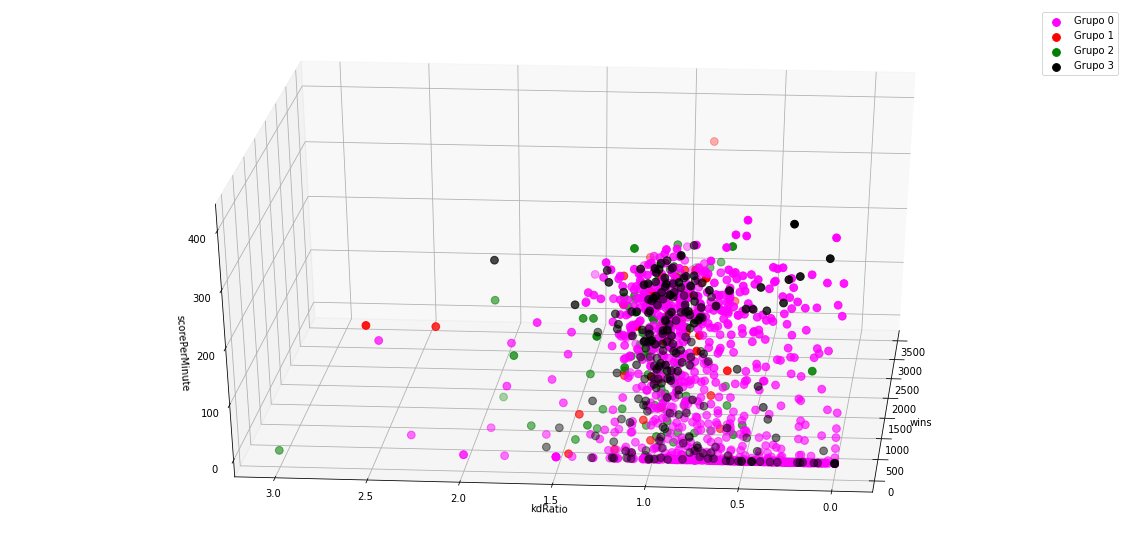

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df.wins[df.label == 0], df["kdRatio"][df.label == 0], df["scorePerMinute"][df.label == 0], c='magenta', label='Grupo 0', s=60)
ax.scatter(df.wins[df.label == 1], df["kdRatio"][df.label == 1], df["scorePerMinute"][df.label == 1], c='red', label='Grupo 1', s=60)
ax.scatter(df.wins[df.label == 2], df["kdRatio"][df.label == 2], df["scorePerMinute"][df.label == 2], c='green', label='Grupo 2', s=60)
ax.scatter(df.wins[df.label == 3], df["kdRatio"][df.label == 3], df["scorePerMinute"][df.label == 3], c='black', label='Grupo 3', s=60)

ax.view_init(30, 185)

plt.xlabel("wins")
plt.ylabel("kdRatio")
ax.set_zlabel('scorePerMinute')

# produce a legend with the unique colors from the scatter
ax.legend()

plt.show()